# Numba 基础

Numba是一个用于Python数组和数值函数的编译器，它使您能够使用直接用Python编写的高性能函数来加速应用程序

Numba使用LLVM编译器基础结构从纯Python代码生成优化的机器代码。通过一些简单的注释，面向数组和Python的数学代码可以被即时优化，性能与C，C ++和Fortran类似，无需切换语言或Python解释器

* CPU and GPU
* numpy based

* [1.1. Overview — Numba 0.36.1-py2.7-macosx-10.6-x86_64.egg documentation](http://numba.pydata.org/numba-doc/0.36.1/user/overview.html)
* [Universal functions (ufunc) — NumPy v1.14 Manual](https://docs.scipy.org/doc/numpy/reference/ufuncs.html)

In [84]:
%matplotlib inline
# 多行结果输出支持
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## numpy 实例

In [14]:
import numpy as np
import numba
numba.__version__

'0.35.0'

In [28]:
# 使用装饰器声明
@numba.jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

x = np.random.randn(8000, 8000) * 5000 ** 3
sum2d(x)

-1029674891704564.1

In [13]:
# 不使用加速
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

x = np.random.randn(8000, 8000) * 5000 ** 3
sum2d(x)

1154353384255752.0

* 由上面的对比可以看出：当数据量较大时,差距相当明显
* 直接使用@numba.jit 是最通用的方式
* 也可以告诉jit函数的类型签名

In [25]:
@numba.jit(nopython=True)
def f(x, y):
    return x + y

f(1, 2)
f(2j, 3)

3

(3+2j)

In [24]:
# 超出 32bit的数值将会被丢弃
@numba.jit([numba.complex128(numba.complex128, numba.complex128)],
          target='cpu')
def f(x, y):
    return x + y

f(1, 2)
# 类型错误
f(2j, 2 + 3j)

(3+0j)

(2+5j)

## 支持的数据类型 

* array types can be specified by indexing any numeric type, e.g. float32[:] for a one-dimensional single-precision array or int8[:,:] for a two-dimensional array of 8-bit integers.
* int32
* void(Python中返回None)
* intp
* uintp(无符号指针)
* intc, uintc (等价于C语言中的有符号和无符号整型)
* `int8`, `uint8`, `int16`, `uint16`, `int32`, `uint32`, `int64`, `uint64` (固定宽度的整型)
* `float32` , `float64` (单精度和双精度浮点型)
* `complex64`, `complex128`(单精度和双精度复数浮点型)

## mode
* nopython（具有最高的性能）
* object

In [31]:
from numba import jit
jit1 = jit(nopython=True, parallel=True)

In [32]:
@jit1
def f(x, y):
    return x + y

In [35]:
from numba import generated_jit, types

@generated_jit(nopython=True)
def is_missing(x):
    """
    Return True if the value is missing, False otherwise.
    """
    if isinstance(x, types.Float):
        return lambda x: np.isnan(x)
    elif isinstance(x, (types.NPDatetime, types.NPTimedelta)):
        # The corresponding Not-a-Time value
        missing = x('NaT')
        return lambda x: x == missing
    else:
        return lambda x: False

# test
is_missing(np.NaN)

True

In [58]:
from numba import vectorize
from numba import (int16, int32, int64, float32, float64, complex128)

In [59]:
vec_cpu = vectorize([
    int16(int16, int16),
    int32(int32, int32),
    int64(int64, int64),
    float32(float32, float32),
    float64(float64, float64),
    complex128(complex128, complex128)
])
@vec_cpu
def f(x, y):
    return x + y

In [60]:
a = np.arange(6)
a
a + a
f(a, a)

array([0, 1, 2, 3, 4, 5])

array([ 0,  2,  4,  6,  8, 10])

array([ 0,  2,  4,  6,  8, 10])

In [61]:
a = np.linspace(0, 1, 6)
a
f(a, a)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ])

In [63]:
a = np.linspace(0, 1+1j, 6)
a
# 没有写支持， 把complex128加入就可以了
f(a, a)

array([ 0.0+0.j ,  0.2+0.2j,  0.4+0.4j,  0.6+0.6j,  0.8+0.8j,  1.0+1.j ])

array([ 0.0+0.j ,  0.4+0.4j,  0.8+0.8j,  1.2+1.2j,  1.6+1.6j,  2.0+2.j ])

In [70]:
# from functools import reduce

In [78]:
a = np.arange(12).reshape(3, 4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [77]:
# numpy 的reduce
f.reduce(a, axis=0)

array([12, 15, 18, 21])

In [73]:
f.reduce(a, axis=1)

array([ 6, 22, 38])

In [75]:
f.accumulate(a)

array([[ 0,  1,  2,  3],
       [ 4,  6,  8, 10],
       [12, 15, 18, 21]])

In [76]:
f.accumulate(a, axis=1)

array([[ 0,  1,  3,  6],
       [ 4,  9, 15, 22],
       [ 8, 17, 27, 38]])

## jitclass 编译Python类

## njit 并行运算

In [81]:
from numba import njit, prange
@njit(parallel=True)
def prange_test(A):
    s = 0
    for i in prange(A.shape[0]):
        s += A[i]
    return s

prange_test(np.array([1, 3, 4, 6, 8]))

22

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

0.16867186699528247


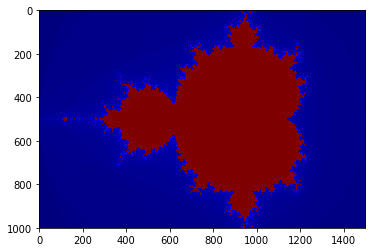

In [92]:

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import jit

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
imshow(image)
jet()
# ion()
show()

In [98]:
import numba
@numba.jit()
def c(n):
    count=0
    for i in range(n):
        for i in range(n):
            count+=1
    return count

n=99999
c(n)

9999800001

In [94]:
def c(n):
    count=0
    for i in range(n):
        for i in range(n):
            count+=1
    return count

n=99999
c(n)

9999800001